# Project Overview: Unsupervised Customer Segmentation for a Grocery Retailer
In this project, I will conduct unsupervised clustering analysis on customer data sourced from a grocery retailer's database. The primary objective is to segment customers into distinct groups based on shared behavioral and transactional patterns.

Customer segmentation is a critical strategy for enhancing business intelligence. By identifying natural clusters within the customer base, the company can tailor its offerings, marketing strategies, and customer engagement efforts to meet the specific needs of each segment. This data-driven approach enables the business to personalize its services, improve customer satisfaction, and ultimately drive revenue growth by focusing resources on high-impact customer groups.

Through this analysis, the business will be empowered to:

Adapt product offerings to match diverse customer preferences.

Design targeted marketing campaigns for each segment.

Improve customer retention by addressing specific behaviors and concerns.

Make informed strategic decisions based on actionable customer insights.

This project leverages unsupervised machine learning to uncover hidden patterns, offering a foundation for more intelligent and efficient business operations.

# Lets Import all the needed libraries

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

Lets now load the data

In [ ]:
data = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

# Data Cleaning and Feature Enggineering

In order to understand the scope lets dive in to the data and explore.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

**Data Preprocessing Insights and Actions:**

Upon initial examination of the dataset, several key issues were identified:

The Income feature contains missing values that could affect clustering performance if left unaddressed.

The Dt_Customer column, which records the customer registration date, is currently stored as an object type and has not been parsed as a proper datetime format.

The dataset includes multiple categorical features (with dtype: object) that must be converted into numerical representations through encoding techniques before being fed into the clustering algorithm.

As a first step in data cleaning, I opted for a straightforward approach by removing rows with missing income values, ensuring a clean and consistent dataset for further processing.


In [ ]:
data = data.dropna()
print("The total number of data-points after cleanup:", len(data))

The total number of data-points after cleanup: 2216


**Feature Engineering: Customer Tenure Calculation**

In the next phase, I will engineer a new feature from the Dt_Customer column to quantify customer tenure—i.e., the number of days each customer has been registered in the firm's database.

To keep the calculation intuitive and relevant, I will compute this value relative to the most recent registration date in the dataset. This approach allows us to standardize the tenure metric across all records, with more recent customers having lower tenure values.

To implement this:

The Dt_Customer column will first be parsed into a proper datetime format.

I will identify the most recent and earliest registration dates for reference.

The new feature, say Customer_Tenure_Days, will be computed as the difference in days between the most recent registration date and each customer's registration date.

This engineered feature will be crucial in understanding customer lifecycle dynamics and segmenting customers based on how long they’ve been engaged with the business.

In [ ]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True)

dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)

# Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in the records:", max(dates))
print("The oldest customer's enrolment date in the records:", min(dates))

The newest customer's enrolment date in the records: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


**Creating the 'Customer_For' Feature:**

To enhance our analysis, I will create a new feature named Customer_For, which represents the number of days each customer has been with the company, calculated relative to the most recent customer registration date in the dataset.

This feature captures customer tenure and provides valuable insight into the customer lifecycle, allowing the business to better understand engagement duration and loyalty patterns across different segments.

In [ ]:
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

Now we will be exploring the unique values in the categorical features to get a clear idea of the data.

In [ ]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


**Feature Engineering Strategy:**

In the next phase of this project, I will engineer several features to enrich the dataset and enhance the clustering process with more meaningful attributes. The planned transformations include:

Age: Derive a customer’s current age by subtracting the Year_Birth from the most recent recorded year in the dataset.

Total Spending (Spent): Aggregate all monetary columns related to customer purchases across various product categories to compute the total amount spent over a two-year period.

Living Situation (Living_With): Reclassify the Marital_Status feature to capture the customer’s living arrangement—distinguishing between those living with a partner and those living alone.

Children: Combine the counts of Kidhome and Teenhome to determine the total number of children or dependents in a customer's household.

Family Size: Create a Family_Size feature by summing the number of adults (inferred from Living_With) and children to reflect the total household size.

Parental Status (Is_Parent): Introduce a binary feature to indicate whether a customer is a parent (i.e., has one or more dependents at home).

Education Simplification: Simplify the Education feature by consolidating similar education levels into three broader categories for clearer segmentation.

Feature Reduction: Drop redundant or low-impact features that no longer add value after transformation, to streamline the dataset for clustering.

These engineered features are designed to capture behavioral, demographic, and socio-economic dimensions more accurately, making the clustering model more robust and interpretable.



In [ ]:
#Feature Engineering
#Age of customer today
data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

<ipython-input-67-303f36e226ea>:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]


Now that we have some new features let's have a look at the data.

In [ ]:
data.describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean    52247.251354     0.441787     0.505415    49.012635   305.091606   
std     25173.076661     0.536896     0.544181    28.948352   337.327920   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35303.000000     0.000000     0.000000    24.000000    24.000000   
50%     51381.500000     0.000000     0.000000    49.000000   174.500000   
75%     68522.000000     1.000000     1.000000    74.000000   505.000000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets         Gold  ...  \
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  ...   
mean     26.356047   166.995939    37.637635    27.028881    43.965253  ...   
std      39.793917   224.283273    54.752082    41.072046    51.815414  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       2.000000    16.000000     3.000000     1.000000     9.000000  ...   
50%       8.000000    68.000000    12.000000     8.000000    24.500000  ...   
75%      33.000000   232.250000    50.000000    33.000000    56.000000  ...   
max     199.000000  1725.000000   259.000000   262.000000   321.000000  ...   

       AcceptedCmp1  AcceptedCmp2     Complain     Response  Customer_For  \
count   2216.000000   2216.000000  2216.000000  2216.000000  2.216000e+03   
mean       0.064079      0.013538     0.009477     0.150271  3.054423e+16   
std        0.244950      0.115588     0.096907     0.357417  1.749036e+16   
min        0.000000      0.000000     0.000000     0.000000  0.000000e+00   
25%        0.000000      0.000000     0.000000     0.000000  1.555200e+16   
50%        0.000000      0.000000     0.000000     0.000000  3.071520e+16   
75%        0.000000      0.000000     0.000000     0.000000  4.570560e+16   
max        1.000000      1.000000     1.000000     1.000000  6.039360e+16   

               Age        Spent     Children  Family_Size    Is_Parent  
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  
mean     52.179603   607.075361     0.947202     2.592509     0.714350  
std      11.985554   602.900476     0.749062     0.905722     0.451825  
min      25.000000     5.000000     0.000000     1.000000     0.000000  
25%      44.000000    69.000000     0.000000     2.000000     0.000000  
50%      51.000000   396.500000     1.000000     3.000000     1.000000  
75%      62.000000  1048.000000     1.000000     3.000000     1.000000  
max     128.000000  2525.000000     3.000000     5.000000     1.000000  

[8 rows x 28 columns]

**Initial Observations and Next Steps:**

Upon reviewing the summary statistics, there are noticeable discrepancies in the data—particularly in the mean and maximum values for both Income and Age. For instance, the calculated maximum age is 128 years, which is highly unrealistic. This anomaly likely stems from the fact that age was computed relative to the current year (2021), while the dataset itself is dated and reflects customer information from earlier years.

To gain a broader and more accurate understanding of the dataset, I will now proceed to visualize key features. This exploratory data analysis (EDA) step will help reveal outliers, trends, and potential data quality issues that may not be immediately obvious from statistical summaries alone.

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

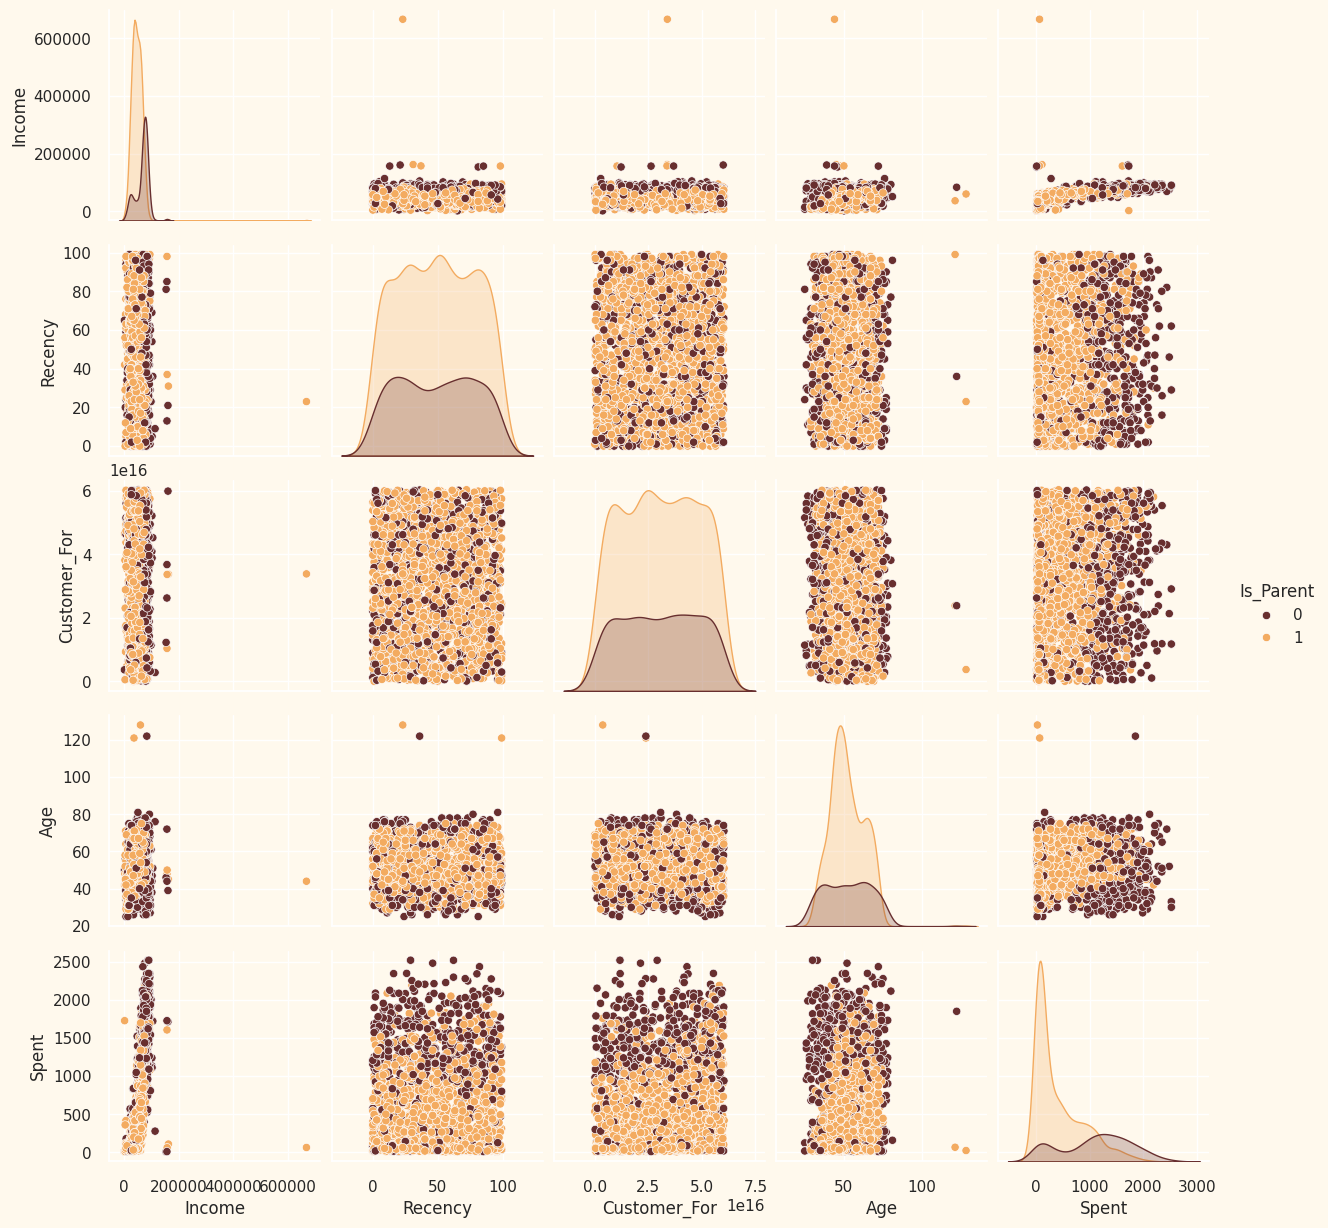

In [ ]:
#To plot some selected features
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue
plt.show()

As you can see there are outlier in age and income. Lets cleanup the outliers.

In [ ]:
#Dropping the outliers by setting a cap on Age and income.
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


Next, let us look at the correlation amongst the features. (Excluding the categorical attributes at this point)

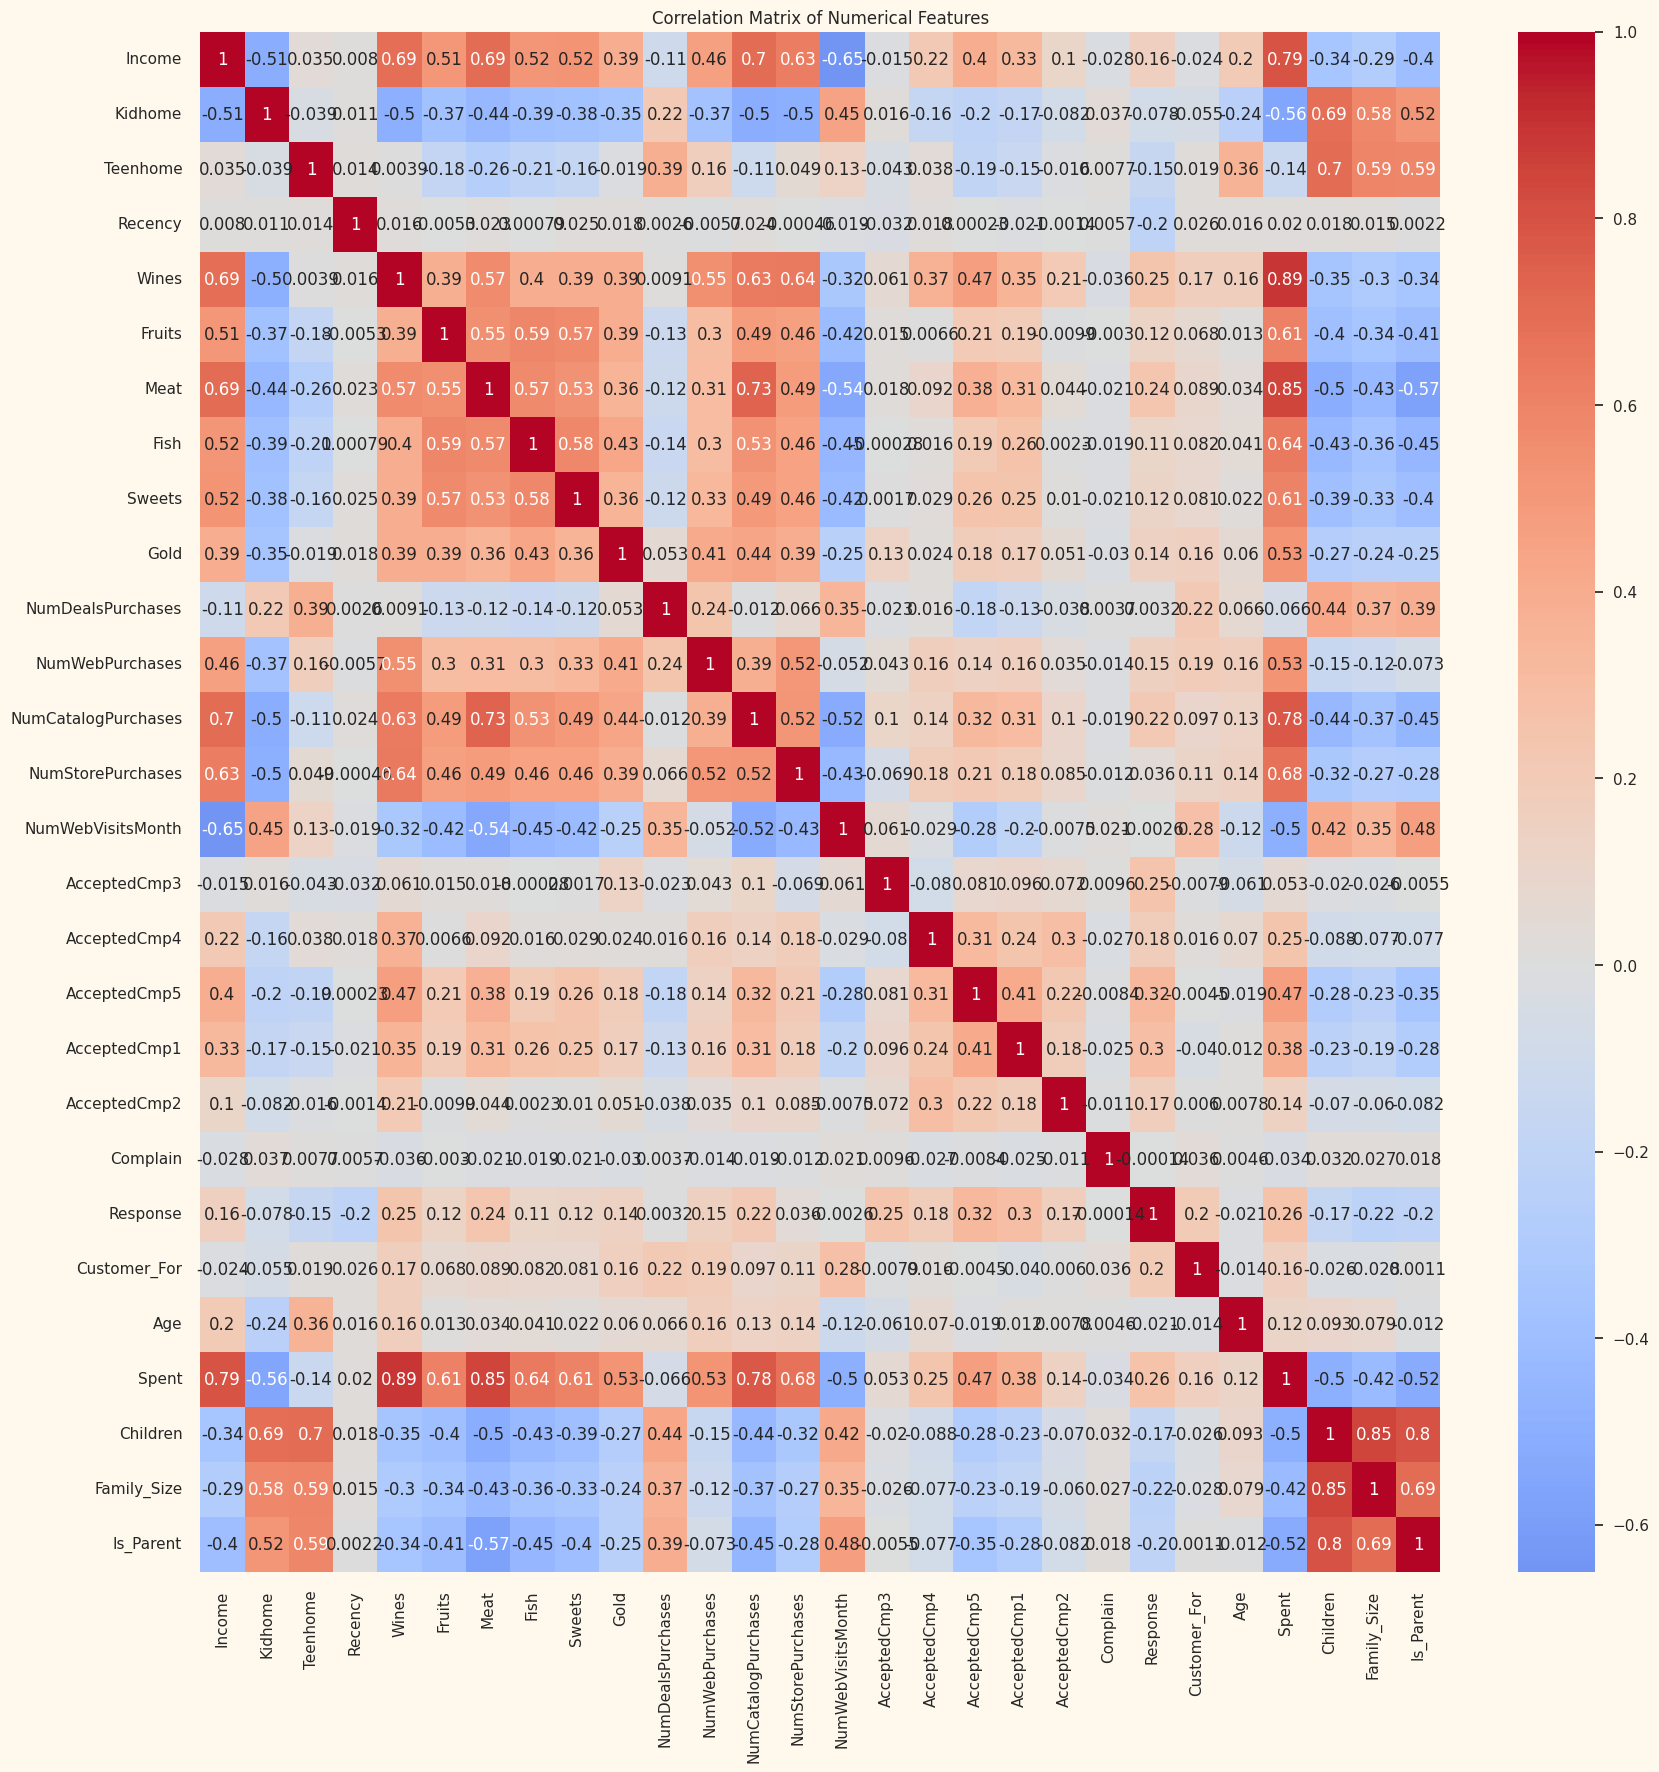

In [ ]:
# Select only numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=['number'])

# Compute correlation matrix
corrmat = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corrmat, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# DATA PREPROCESSING

Data Preprocessing for Clustering

In this section, I will preprocess the dataset to prepare it for clustering. Proper preprocessing ensures that the features are in the optimal format and scale for effective unsupervised learning.

The following key steps will be performed:

Label Encoding: Convert all categorical features into numerical form using label encoding, allowing clustering algorithms to process non-numeric data.

Feature Scaling: Normalize the numerical values using StandardScaler, which transforms the features to have a mean of 0 and a standard deviation of 1. This is critical for distance-based algorithms like K-Means.

Dimensionality Reduction Preparation: Create a cleaned and scaled subset of the dataset to be used for dimensionality reduction techniques such as PCA (Principal Component Analysis) or t-SNE. This helps in both improving clustering performance and enabling visual interpretation in 2D or 3D space.

These preprocessing steps are essential to ensure the quality, consistency, and interpretability of clustering outcomes.

In [ ]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [ ]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

print("All features are now numerical")

All features are now numerical


In [ ]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [ ]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


Education    Income   Kidhome  Teenhome   Recency     Wines    Fruits  \
0  -0.893586  0.287105 -0.822754 -0.929699  0.310353  0.977660  1.552041   
1  -0.893586 -0.260882  1.040021  0.908097 -0.380813 -0.872618 -0.637461   
2  -0.893586  0.913196 -0.822754 -0.929699 -0.795514  0.357935  0.570540   
3  -0.893586 -1.176114  1.040021 -0.929699 -0.795514 -0.872618 -0.561961   
4   0.571657  0.294307  1.040021 -0.929699  1.554453 -0.392257  0.419540   

       Meat      Fish    Sweets  ...  NumCatalogPurchases  NumStorePurchases  \
0  1.690293  2.453472  1.483713  ...             2.503607          -0.555814   
1 -0.718230 -0.651004 -0.634019  ...            -0.571340          -1.171160   
2 -0.178542  1.339513 -0.147184  ...            -0.229679           1.290224   
3 -0.655787 -0.504911 -0.585335  ...            -0.913000          -0.555814   
4 -0.218684  0.152508 -0.001133  ...             0.111982           0.059532   

   NumWebVisitsMonth  Customer_For       Age     Spent  Living_With  Children  \
0           0.692181      1.527721  1.018352  1.676245    -1.349603 -1.264598   
1          -0.132545     -1.189011  1.274785 -0.963297    -1.349603  1.404572   
2          -0.544908     -0.206048  0.334530  0.280110     0.740959 -1.264598   
3           0.279818     -1.060584 -1.289547 -0.920135     0.740959  0.069987   
4          -0.132545     -0.951915 -1.033114 -0.307562     0.740959  0.069987   

   Family_Size  Is_Parent  
0    -1.758359  -1.581139  
1     0.449070   0.632456  
2    -0.654644  -1.581139  
3     0.449070   0.632456  
4     0.449070   0.632456  

[5 rows x 23 columns]

# DIMENSIONALITY REDUCTION

Dimensionality Reduction with PCA

In this dataset, multiple features contribute to the final classification or segmentation. However, working with high-dimensional data introduces complexity and often redundancy, as many features may be correlated and provide overlapping information. To address this, I will apply dimensionality reduction to streamline the dataset while preserving as much valuable information as possible.

Dimensionality reduction reduces the number of input variables by transforming the original features into a smaller set of uncorrelated variables—called principal components—that retain the essence of the data. This not only improves computational efficiency but also enhances data visualization and reduces the risk of overfitting.

Key Technique: Principal Component Analysis (PCA)
Principal Component Analysis (PCA) is a statistical method used to reduce dimensionality while maximizing variance retention. It simplifies complex datasets and helps in revealing underlying patterns.

Steps in This Section:
Apply PCA to reduce the feature space to 3 principal components.

Visualize the reduced dataset to inspect structure, separation, and potential clustering behavior in a lower-dimensional space.

This step will lay the groundwork for efficient clustering and improve the interpretability of the results.

In [ ]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

count          mean       std       min       25%       50%       75%  \
col1  2212.0  5.781993e-17  2.878602 -5.978124 -2.539470 -0.781595  2.386380   
col2  2212.0  6.424437e-17  1.709469 -4.194757 -1.323929 -0.173721  1.234851   
col3  2212.0  1.244735e-17  1.231687 -3.625248 -0.853713 -0.050842  0.863974   

           max  
col1  7.452915  
col2  6.168189  
col3  6.750458

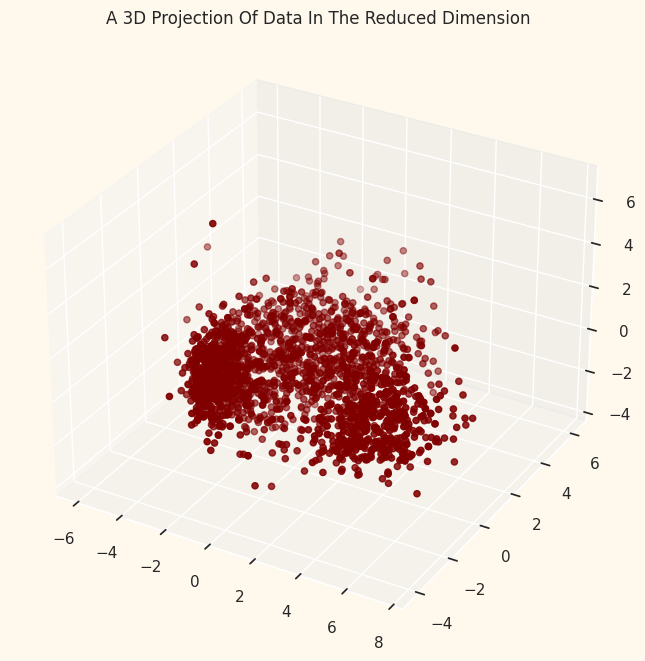

In [ ]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# CLUSTERING

With the dataset reduced to three principal components, I will now proceed with clustering using Agglomerative Clustering—a powerful hierarchical clustering algorithm that builds nested clusters by successively merging or splitting them based on similarity.

Unlike flat clustering methods such as K-Means, Agglomerative Clustering does not require the number of clusters to be defined in advance and constructs a dendrogram that helps identify the optimal cluster count based on the hierarchy of merges.

Steps in the Clustering Process:
Determine Optimal Number of Clusters (Elbow Method)
Although hierarchical clustering doesn’t inherently rely on a predefined k, I will first apply the Elbow Method using distortion or linkage metrics to estimate the optimal number of clusters. This ensures a more informed cluster selection when visualizing and analyzing the results.

Apply Agglomerative Clustering
Using the reduced 3D dataset, I will implement Agglomerative Clustering with the optimal number of clusters identified in the previous step. The method will use a chosen linkage criterion (e.g., ‘ward’, ‘average’, or ‘complete’) and Euclidean distance to form the clusters.

Visualize Clusters in Reduced Dimensions
Finally, I will create a 3D scatter plot of the principal components colored by cluster assignment. This visualization helps to intuitively assess how well-separated and meaningful the clusters are in reduced feature space.

Elbow Method to determine the number of clusters to be formed:


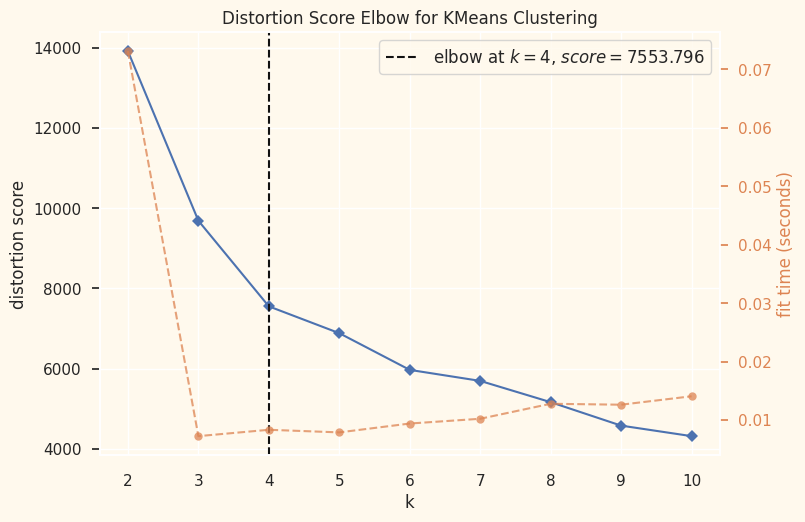

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [ ]:
#Initiating the Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

To examine the clusters formed let's have a look at the 3-D distribution of the clusters.

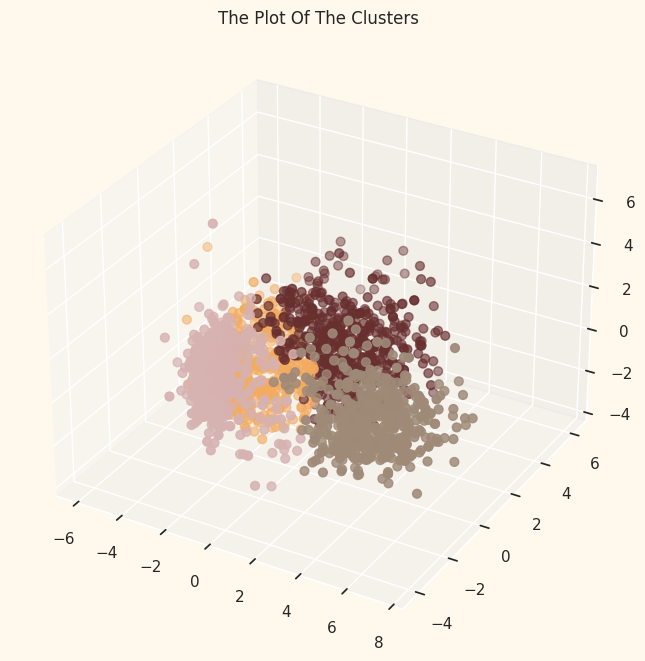

In [ ]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

# EVALUATING MODELS

Here’s a more polished and strategically phrased version of your statement:

---

### **Cluster Interpretation and Exploratory Analysis**

Since this is an **unsupervised clustering task**, we do not have a labeled target feature to directly evaluate the performance of our model. The objective here is not classification accuracy but rather **pattern discovery**—uncovering meaningful structure and customer segments within the data.

The goal of this section is to **analyze the clusters formed** through **exploratory data analysis (EDA)** and **interpret the behavioral traits** and demographic patterns within each cluster. This qualitative evaluation will help assess the business relevance of the groupings.

---

### **Steps for Interpretation:**

1. **Review Cluster Distribution**
   First, we will examine how the data points are distributed across the different clusters. This gives insight into whether the clustering is balanced or skewed, and how many distinct groups have been identified.

2. **EDA on Clustered Data**
   We’ll perform segmented exploratory analysis, comparing key attributes (such as income, spending behavior, family size, etc.) **within and across clusters**. This helps profile each cluster and understand what differentiates one group from another.

3. **Draw Strategic Insights**
   Based on the EDA findings, we will extract actionable insights on customer segments—enabling potential business strategies like **personalized marketing**, **product positioning**, or **customer retention efforts**.

<ipython-input-83-2f63248a592e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=data["Clusters"], palette= pal)


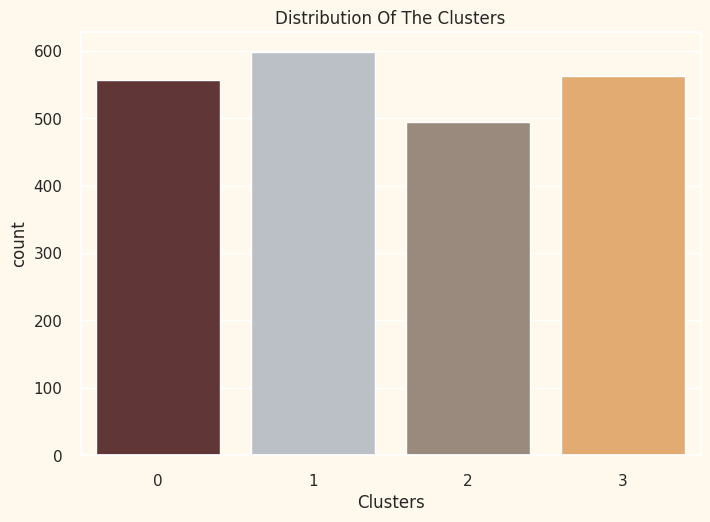

In [ ]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

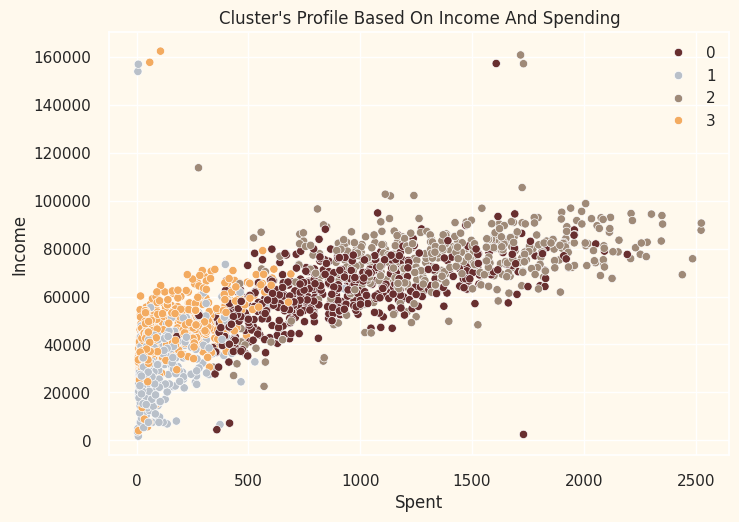

In [ ]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

Income vs spending plot shows the clusters pattern

group 0: high spending & average income
group 1: high spending & high income
group 2: low spending & low income
group 3: high spending & low income
Next, I will be looking at the detailed distribution of clusters as per the various products in the data. Namely: Wines, Fruits, Meat, Fish, Sweets and Gold

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 71.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 56.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-85-b5a4c0fdc6d1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
/usr/local/lib/python3.11/dist-packages/seaborn/ca

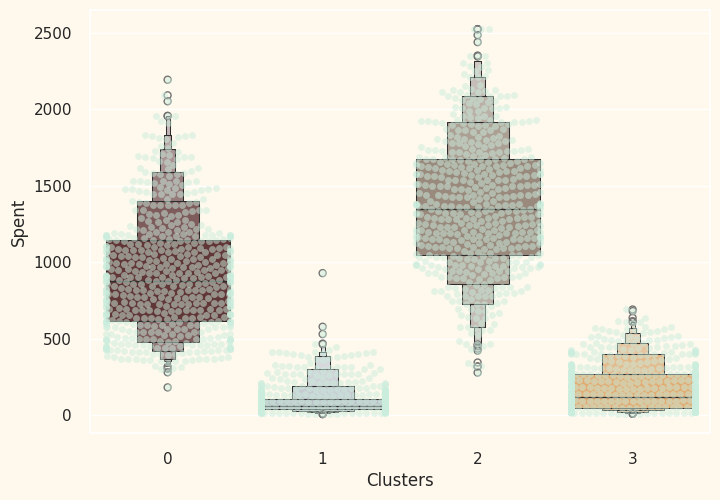

In [ ]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

Cluster Size Analysis and Strategic Implication
From the cluster distribution plot above, it is evident that Cluster 1 represents the largest segment of customers, followed closely by Cluster 0. These dominant segments indicate where the majority of customer activity lies and hence should be the primary focus of targeted marketing efforts.

Understanding what each cluster spends on will allow us to tailor marketing strategies, product offerings, and promotions to better match the preferences and behaviors of each group.

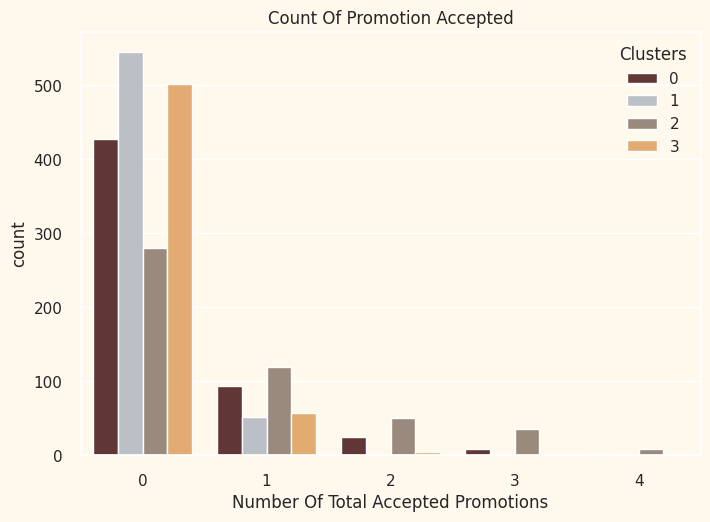

In [ ]:
#Creating a feature to get a sum of accepted promotions
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales.

<ipython-input-88-0ef84d1c8fe9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)


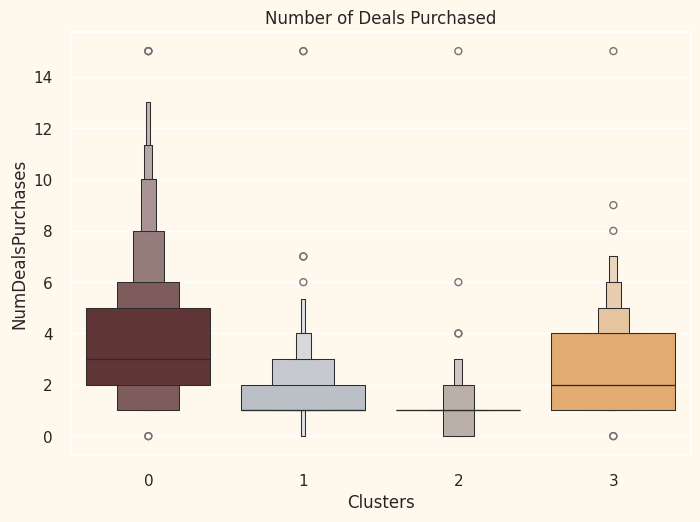

In [ ]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

Campaigns vs Deals: Customer Response Insights
Unlike the underwhelming performance of traditional marketing campaigns, the promotional deals proved significantly more effective—particularly for Cluster 0 and Cluster 3, which showed strong engagement and conversion rates through deal-driven incentives.

However, a critical observation is that Cluster 1, which constitutes our largest and potentially most valuable customer segment, shows limited interest in deals. This indicates that promotional discounts alone may not be an effective lever for influencing their behavior. They may be more responsive to premium services, exclusive memberships, or personalized experiences over generic offers.

On the other hand, Cluster 2 remains largely unresponsive—neither campaigns nor deals appear to influence them significantly. This suggests either a disengaged segment or one that requires a completely different approach, possibly driven by deeper personalization, alternative communication channels, or even product diversification.

# PROFILING

Customer Profiling by Cluster
With the clusters now formed and their spending behavior analyzed, the next crucial step is profiling—understanding who these customers are, beyond just how they spend.

This phase aims to extract actionable insights into the demographic and psychographic characteristics of each cluster, enabling us to:

Identify our high-value "star" customers

Detect segments that are under-engaged or require nurturing

Tailor precision-targeted campaigns based on real customer personas

Approach
To build these profiles, I will analyze key customer attributes such as:

Age

Income

Education

Family size and structure

Marital and parental status

These features will be visualized cluster-wise to reveal how personal traits differ across groups. This enables the marketing team to align their strategies with actual customer identities—not just behaviors.

Objective
By the end of this step, we will be able to:

Define clear personas for each customer segment

Determine which clusters represent high lifetime value (LTV)

Identify which segments require re-engagement strategies or loyalty programs

Let’s dive into the profiling analysis and extract the truths hidden in the data. Ready for the visualizations and conclusions?

<Figure size 800x550 with 0 Axes>

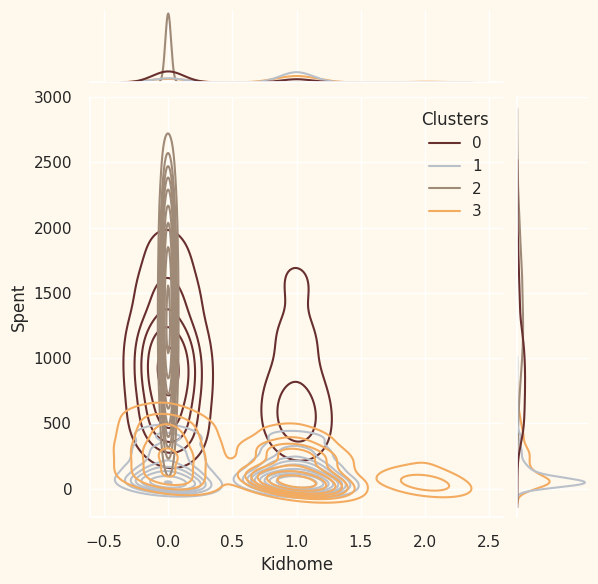

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

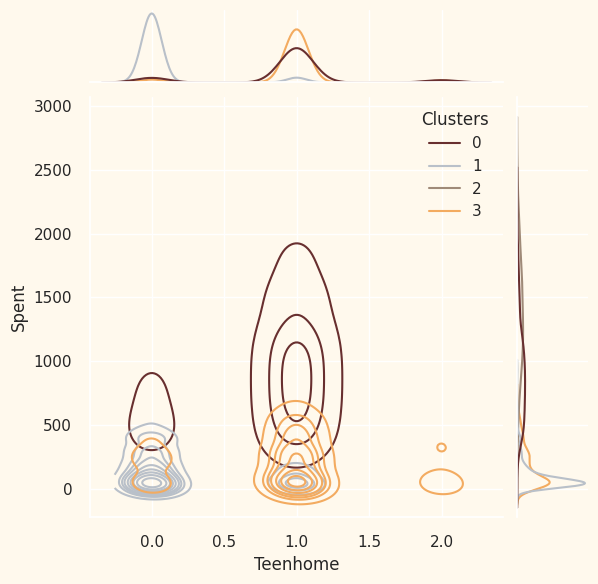

<Figure size 800x550 with 0 Axes>

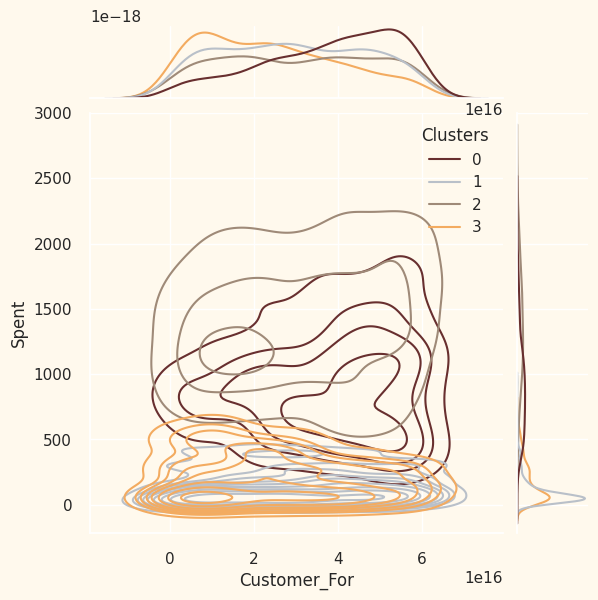

<Figure size 800x550 with 0 Axes>

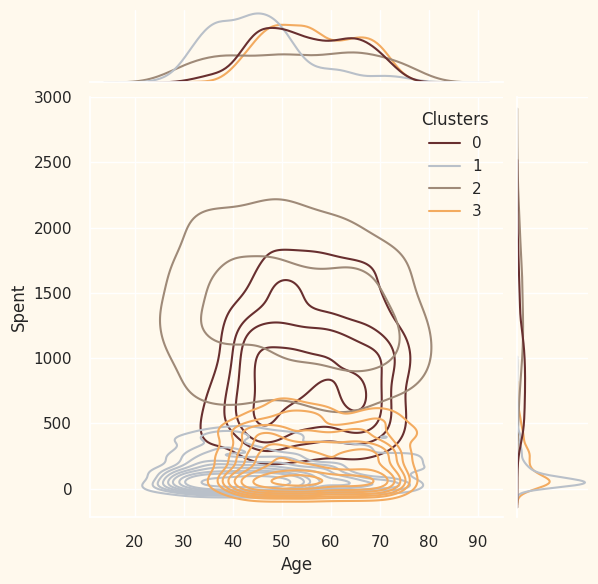

<Figure size 800x550 with 0 Axes>

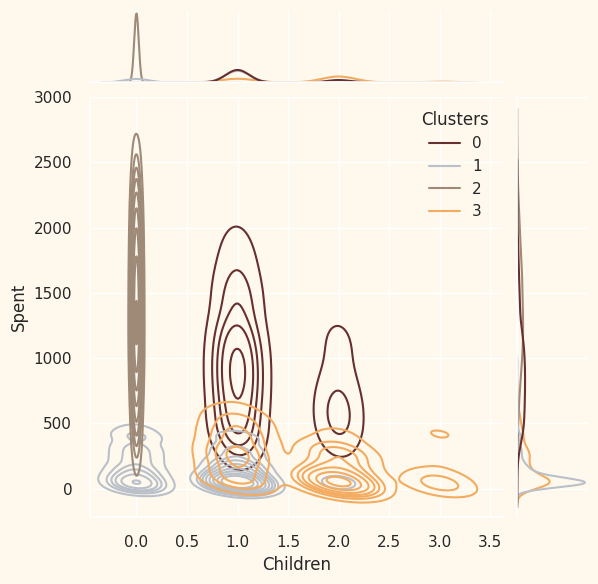

<Figure size 800x550 with 0 Axes>

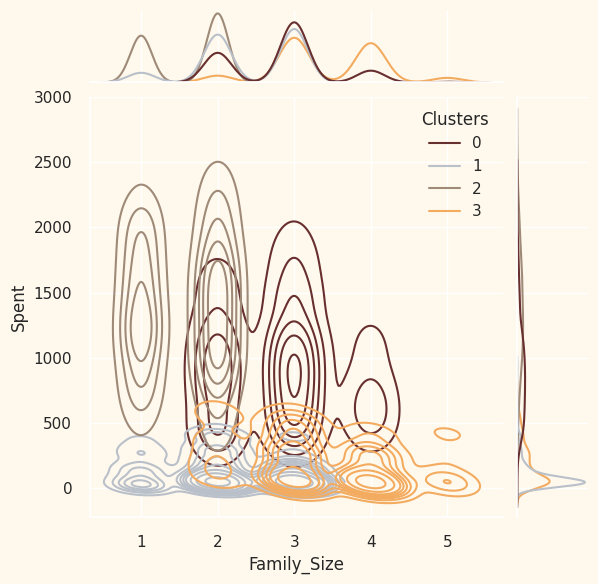

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

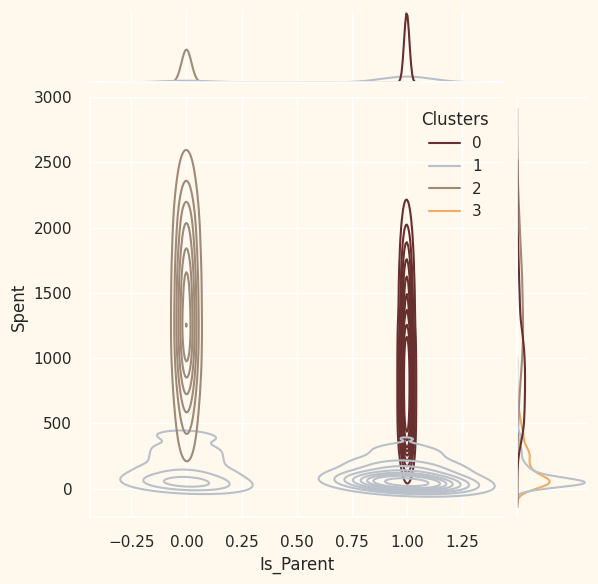

<Figure size 800x550 with 0 Axes>

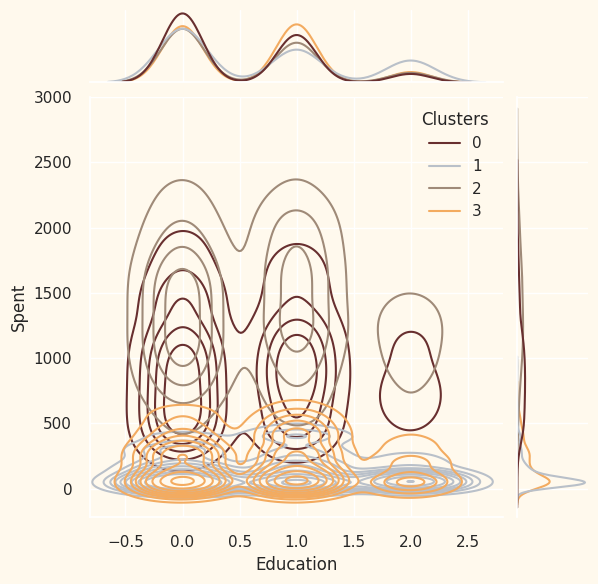

<Figure size 800x550 with 0 Axes>

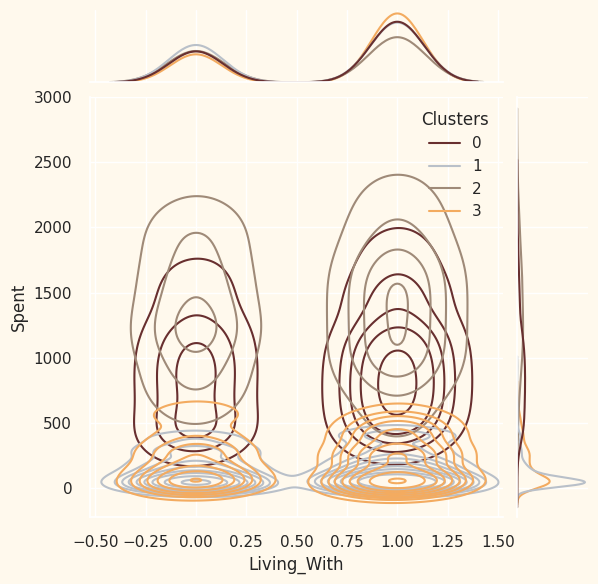

In [ ]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()

# Conclusion
In this project, I successfully applied unsupervised clustering to segment the customer base using a combination of dimensionality reduction (PCA) and agglomerative hierarchical clustering. Four distinct customer clusters emerged, each characterized by unique demographic and spending patterns.

Through detailed customer profiling, focusing on family structure, income, and purchasing behavior, these clusters provide a valuable framework for targeted marketing strategies. Leveraging these insights enables the business to optimize campaign effectiveness, personalize offers, and ultimately increase customer lifetime value.

This analytical approach lays a robust foundation for data-driven decision making—transforming raw data into actionable customer intelligence and competitive advantage.

